### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

Text(-45, 55, 'NAH')

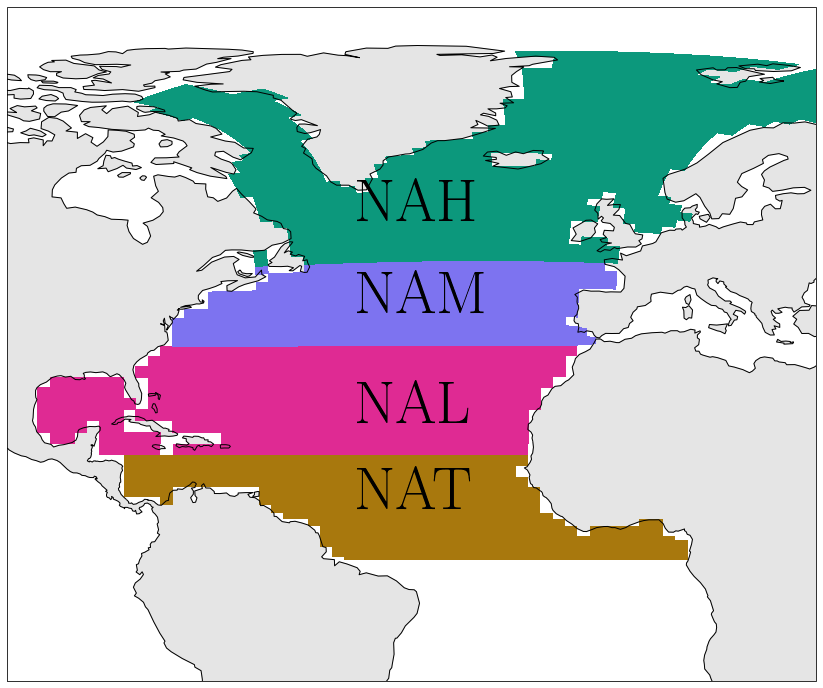

In [4]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

    
regs = ['NAT', 'NAL', 'NAM', 'NAH']#, 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'NAT' : {'number' : 1},
           'NAL' : {'number': 2},
          'NAM' : {'number': 3},
           'NAH' : {'number': 4},
           
          }

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[atl[regs[i]][0,0,:,:] == 1] = regdict[regs[i]]['number']
maskno[maskno == 0] = np.nan

fact = 1
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())

year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
mesh = ax.pcolormesh(nav_lon, nav_lat, maskno, transform=ccrs.PlateCarree(), cmap=cm.phase, zorder =0, alpha = 1,\
                    vmin = 1, vmax = 5)

ax.coastlines(zorder = 1 )
#lons, lats extent
ax.set_extent([ -102, 30, -20, 120,], crs=ccrs.PlateCarree())

ax.add_feature(cp.feature.LAND, color='grey', alpha = 0.2)
fs = 60
ax.text(-45, 8, s = f'NAT', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 22, s = f'NAL', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 40, s = f'NAM', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 55, s = f'NAH', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())

## area-weighted province maps

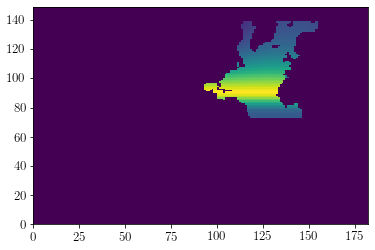

In [5]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

(atl)

area_broad = np.zeros([1,31,149,182])

for i in range(0,31):
    
    area_broad[0,i,:,:] = atl.tmask[0,i,:,:]*atl.e1t[0,:,:]*atl.e2t[0,:,:]

atl['NAT_area'] = atl.NAT * area_broad
atl['NAL_area'] = atl.NAL * area_broad
atl['NAM_area'] = atl.NAM * area_broad
atl['NAH_area'] = atl.NAH * area_broad
atl['ATL_area'] = atl.ATL * area_broad

plt.figure()
plt.pcolormesh(atl.ATL_area[0,0,:,:])

atl = atl.rename({'z': 'deptht'})
atl = atl.squeeze(dim='t')

## get PPINT out of individual prophy files!

In [6]:
def get_PPINT(yr,run = 'TOM12_TJ_LA02', save = True):
    print(yr)
    tdir = f'/gpfs/data/greenocean/software/runs/{run}/'
    dia = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_dia_ATL_T.nc')
    mix = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_mix_ATL_T.nc')
    coc = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_coc_ATL_T.nc')
    pha = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_pha_ATL_T.nc')
    fix = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_fix_ATL_T.nc')
    pic = xr.open_dataset(f'/{tdir}/ORCA2_1m_{yr}0101_{yr}1231_prophy_pic_ATL_T.nc')
    
    tds = xr.merge([dia,mix,coc,pic,pha,fix])
    
    if save:
        tds.to_netcdf(f'{tdir}/ORCA2_1m_{yr}0101_{yr}1231_PPINT_T.nc')
    return tds

ex = False
if ex:
    for yr in range(1950,2000):
        get_PPINT(yr)

## get a depth profile of all species in atl, ppint, etc

save first as netcdf

put this in extract_dp.py


## timeseries of pfts and ppints

In [7]:
w = xr.open_dataset('./data/LA02-ptrc_1951-ATL.nc')

prov = ['ATL','NAT','NAL','NAM','NAH',]

def make_yearlist(yrst, yrend, typ = 'ptrc', nam = 'LA02', prov = 'ATL'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    
    for yr in (yrs):

        tyr = glob.glob(f'./data/{nam}-{typ}_{yr}-{prov}.nc')

        ylist.append(tyr)
        
    return ylist

yst = 1951; yen = 1989
ptrc_ATL = xr.open_mfdataset(make_yearlist(1951,yen,'ptrc','LA02','ATL'))
ptrc_NAT = xr.open_mfdataset(make_yearlist(1951,yen,'ptrc','LA02','NAT'))
ptrc_NAL = xr.open_mfdataset(make_yearlist(1951,yen,'ptrc','LA02','NAL'))
ptrc_NAM = xr.open_mfdataset(make_yearlist(1951,yen,'ptrc','LA02','NAM'))
ptrc_NAH = xr.open_mfdataset(make_yearlist(1951,yen,'ptrc','LA02','NAH'))

ppint_ATL = xr.open_mfdataset(make_yearlist(1951,yen,'ppint','LA02','ATL'))
ppint_NAT = xr.open_mfdataset(make_yearlist(1951,yen,'ppint','LA02','NAT'))
ppint_NAL = xr.open_mfdataset(make_yearlist(1951,yen,'ppint','LA02','NAL'))
ppint_NAM = xr.open_mfdataset(make_yearlist(1951,yen,'ppint','LA02','NAM'))
ppint_NAH = xr.open_mfdataset(make_yearlist(1951,yen,'ppint','LA02','NAH'))

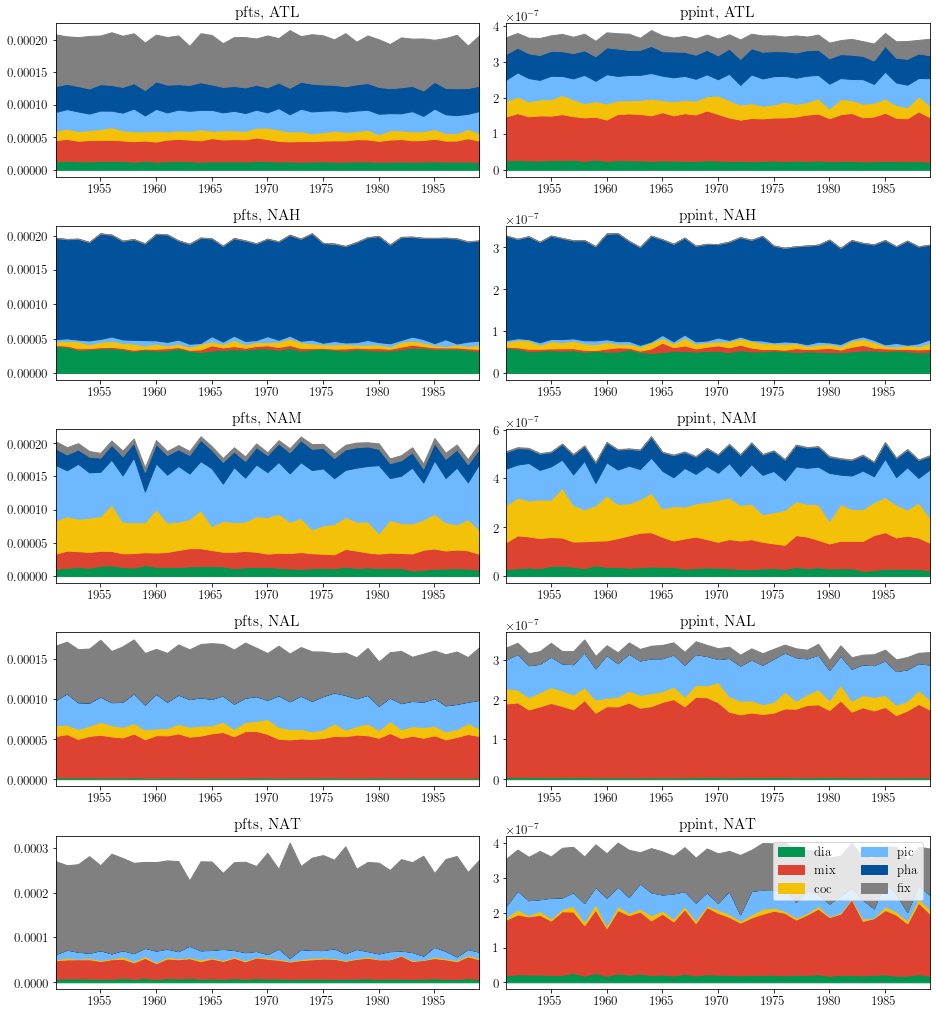

In [8]:
fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(12*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvarssmol = ['dia','mix','coc','pic','pha','fix']
tvars = ['dia','mix']
metro = ['#02954f', '#de4231','#f3c108','#6db8ff','#01529b','grey']
noy = yen-yst+1

tvars = ['DIA','MIX','COC','PIC','PHA','FIX']
provs = [ptrc_ATL,ptrc_NAH,ptrc_NAM,ptrc_NAL,ptrc_NAT,]
provs2 = [ppint_ATL,ppint_NAH,ppint_NAM,ppint_NAL,ppint_NAT,]
for p in range(0,5):
    
    ds = provs[p]
    ds2 = provs2[p]

    cumulative = np.zeros([noy])

    ind = 0
    for var in tvars:

        dia = (ds[var] * atl.e3t_1d).sum(dim = 'deptht')
        times =dia.indexes['time_counter'].to_datetimeindex()
        values = dia.groupby('time_counter.year').mean()
        new_cumulative = cumulative + values.values
        # print(cumulative)
        # print(new_cumulative)
        # Use fill_betweenx to create the stacked profile
        axs[p*2].fill_between(values.year, cumulative, new_cumulative,\
                         label=var, color = metro[ind])
        
        cumulative = new_cumulative
        ind = ind+1
    axs[p*2].set_xlim([yst,yen])
        
    ind = 0
    cumulative = np.zeros([noy])
    for var in tvarssmol:

        dia = (ds2[var] * atl.e3t_1d).sum(dim = 'deptht')
        times =dia.indexes['time_counter'].to_datetimeindex()
        values = dia.groupby('time_counter.year').mean()
        new_cumulative = cumulative + values
        # print(cumulative)
        # print(new_cumulative)
        # Use fill_betweenx to create the stacked profile
        axs[p*2+1].fill_between(values.year, cumulative, new_cumulative,\
                         label=var, color = metro[ind])
        cumulative = new_cumulative
        ind = ind+1
    axs[p*2+1].set_xlim([yst,yen])
        
axs[9].legend(ncol = 2, loc = 'best')

tits = ['pfts, ATL', 'ppint, ATL', 'pfts, NAH', 'ppint, NAH', \
        'pfts, NAM', 'ppint, NAM', 'pfts, NAL', 'ppint, NAL', \
        'pfts, NAT', 'ppint, NAT'] 
for i in range(0,10):
    axs[i].set_title(tits[i])
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])
    
plt.tight_layout()


# get out the actual AMOC

    - fortran step in master cheatsheet

In [9]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

def make_amoc_nc(simulationID, yrFrom = 1959, yrTo = 2022):

    tmoc = xr.open_mfdataset(make_yearlist(yrFrom, yrTo, simulationID))
    tdat = get_max_amoc(tmoc)
    nicetime = tmoc.indexes['time_counter'].to_datetimeindex()

    resultsdir = '/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/'
    parm = 'AMOC'
    outputFile = f'{resultsdir}{parm}_{simulationID}_{yrFrom}-{yrTo}.nc'
    print(outputFile)
    
    data_vars = {'AMOC':(['TIME'], tdat,
    {'units': 'Sv',
    'long_name':'Atlantic Meridional Overturning Circulation, max of streamfunction at 26N'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'AMOC-PLANKTOM/makeAMOC_modelts.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)
    
ml = ['TJ_LA02']
extract = False
if extract:
    
    for m in ml:

        tnam = f'TOM12_{m}'
        tst = 1940
        ten = 2003
        print(f'{tnam} {tst} {ten}')
        make_amoc_nc(tnam, yrFrom = tst, yrTo = ten)


## regress phyto variability against amoc variability and put in dataframe

In [10]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

from scipy.stats import pearsonr

        #print(f'{reg} {correlation_coefficient}, {p}')

In [21]:
provs = [ptrc_ATL,ptrc_NAT,ptrc_NAL,ptrc_NAM,ptrc_NAH]
provs2 = [ppint_ATL,ppint_NAT,ppint_NAL,ppint_NAM,ppint_NAH]

def get_df(ds, dssav, save = True, yrst = 1951, yrend = 1989, typ = 'ptrc'):

    
    data = np.zeros([5,6])
    if typ == 'ptrc':
        df = pd.DataFrame(data, columns=['DIA','MIX','COC','PIC','PHA','FIX'],\
                          index  = ['FY','DJF','MAM', 'JJA', 'SON',])
    if typ == 'ppint':
        df = pd.DataFrame(data, columns=['dia','mix','coc','pic','pha','fix'],\
                  index  = ['FY','DJF','MAM', 'JJA', 'SON',])

    am = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_LA02_1940-2003.nc')

    am2 = am.AMOC.sel(TIME=slice(f'{yrst}-01-01', f'{yrend}-12-31'))

    seas = ['FY','DJF','MAM', 'JJA', 'SON']
    tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

    for var in tvars:

        if typ == 'ptrc':
            tphy = ds[var]
        if typ == 'ppint':
            var = var.lower()
            tphy = ds[var]
            
        for s in seas:

            if s == 'FY':
                phythis = tphy.groupby('time_counter.year').mean()
                phythis = (phythis * atl.e3t_1d).sum(dim = 'deptht')
            else:
                phythis = tphy.sel(time_counter=tphy.time_counter.dt.season==s).groupby('time_counter.year').mean()    
                phythis = (phythis * atl.e3t_1d).sum(dim = 'deptht')

            if s == 'FY':
                amthis = am2.groupby('TIME.year').mean()
            else:
                amthis = am2.sel(TIME=am2.TIME.dt.season==s).groupby('TIME.year').mean()

            cc, p = pearsonr(amthis, phythis)
            
            df.loc[s, var] = cc
    
    if save:
        print(f'./data/{dssav}_corr-vs-AMOC.nc')
        df.to_csv(f'./data/{dssav}_corr-vs-AMOC.nc')
    print('done')
    
provs = [ptrc_ATL,ptrc_NAT,ptrc_NAL,ptrc_NAM,ptrc_NAH]
provs2 = [ppint_ATL,ppint_NAT,ppint_NAL,ppint_NAM,ppint_NAH]


tfix = ['ptrc_ATL','ppint_ATL', 'ptrc_NAH','ppint_NAH',\
        'ptrc_NAM','ppint_NAM', 'ptrc_NAL','ppint_NAL',\
        'ptrc_NAT','ppint_NAT']

tfix2 = [ptrc_ATL,ppint_ATL, ptrc_NAH,ppint_NAH,\
        ptrc_NAM,ppint_NAM, ptrc_NAL,ppint_NAL,\
        ptrc_NAT,ppint_NAT]

typ = ['ptrc','ppint','ptrc','ppint','ptrc','ppint',\
       'ptrc','ppint','ptrc','ppint']

for i in range(0,10):
    
    get_df(tfix2[i], tfix[i], typ = typ[i])



./data/ptrc_ATL_corr-vs-AMOC.nc
done
./data/ppint_ATL_corr-vs-AMOC.nc
done
./data/ptrc_NAH_corr-vs-AMOC.nc
done
./data/ppint_NAH_corr-vs-AMOC.nc
done
./data/ptrc_NAM_corr-vs-AMOC.nc
done
./data/ppint_NAM_corr-vs-AMOC.nc
done
./data/ptrc_NAL_corr-vs-AMOC.nc
done
./data/ppint_NAL_corr-vs-AMOC.nc
done
./data/ptrc_NAT_corr-vs-AMOC.nc
done
./data/ppint_NAT_corr-vs-AMOC.nc
done


## plot of heatmaps 

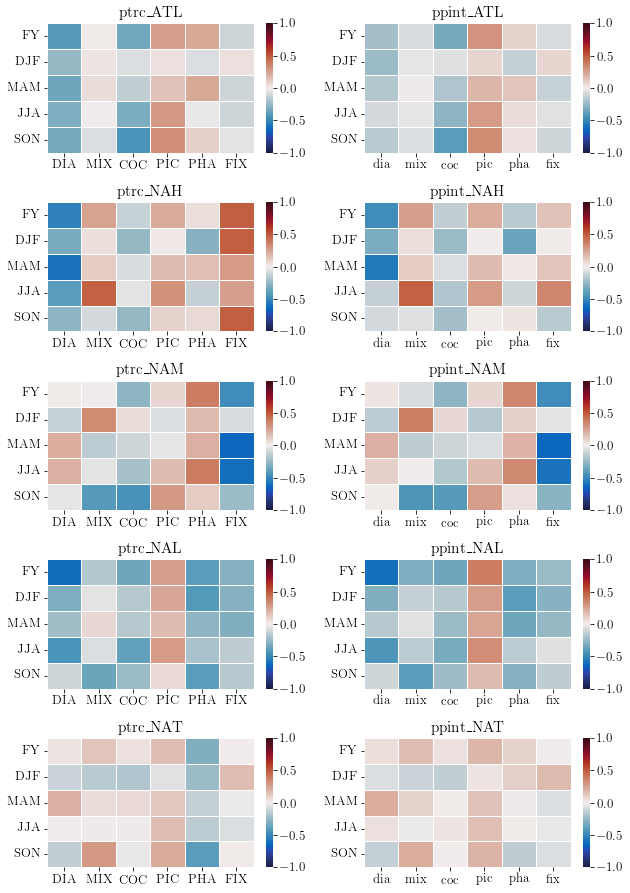

In [22]:
import seaborn as sns

tfix = ['ptrc_ATL','ppint_ATL', 'ptrc_NAH','ppint_NAH',\
        'ptrc_NAM','ppint_NAM', 'ptrc_NAL','ppint_NAL',\
        'ptrc_NAT','ppint_NAT']


tcmap = cm.balance
vmin = -1
vmax = 1

fact = 0.9
fig, axs = plt.subplots(5,2, figsize=(10*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,10):
    
    df = pd.read_csv(f'./data/{tfix[i]}_corr-vs-AMOC.nc', index_col=0)
    sns.heatmap(df, cmap=tcmap, linewidths=0.5, annot=False, vmin = vmin, vmax = vmax, ax = axs[i])
    axs[i].set_title(tfix[i])
    
plt.tight_layout()

# garbage

In [13]:
data = np.zeros([5,6])
df = pd.DataFrame(data, columns=['DIA','MIX','COC','PIC','PHA','FIX'],\
                  index  = ['FY','DJF','MAM', 'JJA', 'SON',])


am = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_LA02_1940-2003.nc')

am2 = am.AMOC.sel(TIME=slice(f'{1951}-01-01', f'{1989}-12-31'))

seas = ['FY','DJF','MAM', 'JJA', 'SON']
tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

for var in tvars:
    
    tphy = ds[var]

    for s in seas:

        if s == 'FY':
            phythis = tphy.groupby('time_counter.year').mean()
            phythis = (phythis * atl.e3t_1d).sum(dim = 'deptht')
        else:
            phythis = tphy.sel(time_counter=tphy.time_counter.dt.season==s).groupby('time_counter.year').mean()    
            phythis = (phythis * atl.e3t_1d).sum(dim = 'deptht')
            
        if s == 'FY':
            amthis = am2.groupby('TIME.year').mean()
        else:
            amthis = am2.sel(TIME=am2.TIME.dt.season==s).groupby('TIME.year').mean()

        
        df.loc[seas, var] = 2

KeyError: 'time_counter.year'

In [ ]:
cols = ['DIA','MIX','COC','PIC','PHA','FIX']



provs = [ptrc_ATL,ptrc_NAT,ptrc_NAL,ptrc_NAM,ptrc_NAH]
provs2 = [ppint_ATL,ppint_NAT,ppint_NAL,ppint_NAM,ppint_NAH]

data = np.zeros([5,6])
df = pd.DataFrame(data, columns=['DIA','MIX','COC','PIC','PHA','FIX'],\
                  index  = ['FY','DJF','MAM', 'JJA', 'SON',])

df.loc['FY', 'DIA'] = 2

df

## one decade

In [ ]:
ex = False

yrst = 1950; yrend = 1959

if ex:
    
    ylist = make_yearlist(yrst, yrend)
    ppint = xr.open_mfdataset(ylist)
    ylist = make_yearlist(yrst, yrend, typ = 'diad')
    diad = xr.open_mfdataset(ylist)
    ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
    ptrc = xr.open_mfdataset(ylist)

    msks = ['ATL', 'NAT','NAL','NAM','NAH']
    tdats = [ptrc, diad, ppint]
    tdatns = ['ptrc', 'diad', 'ppint']
    for i in range(2,3):
        tdat = tdats[i]
        tdatn = tdatns[i]
        for mask in msks:
            tdatnam = f'{tdatn}_'
            masknam = f'{mask}_area'
            savenam = f'./data/{tdatnam}{yrst}-{yrend}-{mask}.nc'
            
            print(savenam)
            ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
            weighted(atl[mask]).mean(dim = ['x','y'])
            ds.to_netcdf(savenam)

In [ ]:
ex = False

yrst = 1951; yrend = 2023

if ex:
    
    for yr in (yrst,yrend):
        try:
            yrst = yr; yrend = yr

            ylist = make_yearlist(yrst, yrend)
            ppint = xr.open_mfdataset(ylist)
            ylist = make_yearlist(yrst, yrend, typ = 'diad')
            diad = xr.open_mfdataset(ylist)
            ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
            ptrc = xr.open_mfdataset(ylist)

            msks = ['ATL', 'NAT','NAL','NAM','NAH']
            tdats = [ptrc, diad, ppint]
            # tdatns = ['ptrc', 'diad', 'ppint']
            # for i in range(0,1):
            #     tdat = tdats[i]
            #     tdatn = tdatns[i]
            for mask in msks:
                tdatn = 'ptrc'; tdat = ptrc
                q = ['O2','PIIC','DOC','CaCO3','ARA','POC','GOC','BSi','GON']
                tdat = tdat.drop_vars(q)
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])
                ds.to_netcdf(savenam)
                #print(ds)

                tdatn = 'diad'; tdat = diad
                #print(list(tdat.variables))
                q2 = [
                 'time_counter_bounds','CARBTRP','CAPITRP','ALKTRP','GRAMIC',
                 'GRAMES','GRAMAC','PPTDOC','Detrit','Carniv',
                 'Herbiv','GRAMICPHY','GRAPTEPHY','GRAMESPHY','GRAGELPHY',
                 'GRAMACPHY','nitrfix','denitr','DELO2','vsink','sinksil','discarb','ExpCO3','ExpARA',
                 'GRAGEL','GRAPTE','proara','prococ','lim2mmfe_dia','lim2mmfe_mix','lim2mmfe_coc','lim2mmfe_pic',
                 'lim2mmfe_pha','lim2mmfe_fix','PICflx','Oflx',]
                tdat = tdat.drop_vars(q2)
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])            
                ds.to_netcdf(savenam)

                tdatn = 'ppint'; tdat = ppint
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])            
                ds.to_netcdf(savenam)
        except:
            print(f'yr {yr} problem')

## plotting code

In [ ]:
ds = xr.open_dataset('./data/ptrc_1950-ATL.nc')

In [ ]:
ds = xr.open_dataset('./data/ptrc_1950-ATL.nc')
metro = ['#02954f', '#de4231','#f3c108','#6db8ff','#01529b','grey']

tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

fig, ax = plt.subplots(figsize=(8, 6))

# Track the cumulative sum to create stacking effect
cumulative = np.zeros_like(ds.deptht.values)
# Plot each variable
ind = 0
for var in tvars:
    # Get the data for the variable
    values = np.squeeze(ds[var].sel(season = ds.season == 'JJA').sel(t = 0).values)
    
    # Calculate the new cumulative total
    new_cumulative = cumulative + values
    # print(cumulative)
    # print(new_cumulative)
    # Use fill_betweenx to create the stacked profile
    ax.fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                     label=var, color = metro[ind])
    
    # Update cumulative for the next stack
    cumulative = new_cumulative
    ind = ind+1

# Invert y-axis if depth is positive going downward
ax.set_ylim([0,180])
#ax.set_xlim([0,1e-13])
ax.invert_yaxis()


# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Depth')
ax.legend(title='Variables')
plt.show()

In [ ]:
# for yr in range(1950,2023):
#     try:
#         w = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_PPINT_T.nc')
#     except:
#         print(yr)


In [ ]:

# fact = 1.1
# fig, axs = plt.subplots(5,4, figsize=(12*fact, 16*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()
# regs = ['ATL', 'NAT', 'NAL', 'NAM', 'NAH']
# seas = ['DJF','MAM','JJA','SON']
# ind = 0
# for i in range(0,5):
#     for d in range(0,4):
        
#         ds = xr.open_dataset(f'./data/ppint_1950-{regs[i]}.nc')
        
#         axs[ind].set_title(f'{regs[i]} {seas[d]}')
        
#         cumulative = np.zeros_like(ds.deptht.values)
    
#         mv = 0
#         for var in tvars:
#             # Get the data for the variable
#             vara = var.lower()
#             tseas = seas[d]
#             values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

#             # Calculate the new cumulative total
#             new_cumulative = cumulative + values
#             # Use fill_betweenx to create the stacked profile
#             axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
#                              label=var, color = metro[mv])
#             mv=mv+1
#             # Update cumulative for the next stack
#             cumulative = new_cumulative
        
#         axs[ind].set_ylim([0,180])
#         axs[ind].set_xlim([0,1.5e-8])
#         axs[ind].invert_yaxis()
#         ind = ind+1

#         # Invert y-axis if depth is positive going downward



In [ ]:
fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
regs = ['NAT', 'NAL', 'NAM', 'NAH']
seas = ['MAM','JJA']
ind = 0
for d in range(0,2):
    for i in range(0,4):

        ds = xr.open_dataset(f'./data/ppint_1956-{regs[i]}.nc')
        
        if ind < 4:
            axs[ind].set_title(f'{regs[i]}')
        
        cumulative = np.zeros_like(ds.deptht.values)
    
        mv = 0
        for var in tvars:
            # Get the data for the variable
            vara = var.lower()
            tseas = seas[d]
            values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

            # Calculate the new cumulative total
            new_cumulative = cumulative + values
            # Use fill_betweenx to create the stacked profile
            axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                             label=var, color = metro[mv])
            mv=mv+1
            # Update cumulative for the next stack
            cumulative = new_cumulative
        
        axs[ind].set_ylim([5,180])
        axs[ind].set_xlim([0,1.5e-8])
        axs[ind].invert_yaxis()
        axs[ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[ind].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        ind = ind+1
        axs[0].legend(loc = 'best')
        axs[0].set_ylabel('m')
        axs[4].set_xlabel('mol C m$^{-3}$ s$^{-1}$')

        # Invert y-axis if depth is positive going downward


### 
fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
regs = ['NAT', 'NAL', 'NAM', 'NAH']
seas = ['MAM','JJA']
ind = 0
for d in range(0,2):
    for i in range(0,4):

        ds = xr.open_dataset(f'./data/ptrc_1956-{regs[i]}.nc')
        
        if ind < 4:
            axs[ind].set_title(f'{regs[i]}')
        
        cumulative = np.zeros_like(ds.deptht.values)
    
        mv = 0
        for var in tvars:
            # Get the data for the variable
            vara = var#.lower()
            tseas = seas[d]
            values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

            # Calculate the new cumulative total
            new_cumulative = cumulative + values
            # Use fill_betweenx to create the stacked profile
            axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                             label=var, color = metro[mv])
            mv=mv+1
            # Update cumulative for the next stack
            cumulative = new_cumulative
        
        axs[ind].set_ylim([5,180])
        axs[ind].set_xlim([0,8.5e-6])
        axs[ind].invert_yaxis()
        axs[ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[ind].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        ind = ind+1
        axs[0].legend(loc = 'best')
        axs[0].set_ylabel('m')
        axs[4].set_xlabel('mol C m$^{-3}$')

        # Invert y-axis if depth is positive going downward



In [ ]:
plt.figure()
plt.title('SPRING     SUMMER')

## who is limiting

In [ ]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_LC02//ORCA2_1m_19560101_19561231_LoP_T.nc')
tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

q = w['LN_dia'].values
print(np.shape(q))

per = np.zeros([6,4,12])

for v in range(0,6):
    
    tvar = tvars[v].lower()
    tvar2 = f'LN_{tvar}'
    print(tvar2)
    for p in range(3,7):

        for i in range(0,12):

            
            test = w[tvar2][i,0:11,:,:].values
            test2 = np.zeros_like(test)
            test2[test == p] = 1

            per[v,p-3,i] = np.nansum(test2*atl.ATL_area[0,0:11,:,:])/np.nansum(atl.ATL_area[0,0:11,:,:])
    # * atl.ATL_area.values
    #test = np.nansum
percs = (np.nanmean(per, axis = 2))

In [ ]:
import matplotlib.pyplot as plt

# Data for the pie chart
# Hex code for mauve is #E0B0FF

# Creating the pie chart

tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
for i in range(0,6):
    
    values = percs[i,:]
    labels = ['Fe', 'PO$_4$', 'Si', 'NO$_3$']

    # Colors for the chart, replacing 'mauve' with its hex code approximation
    colors = ['y', 'b', 'r', 'chartreuse']  
    axs[i].pie(values, labels=labels, colors=colors, startangle=90)
    axs[i].set_title(tvars[i])
    # plt.title('Pie Chart with Custom Colors')
    # plt.show()
    plt.tight_layout()

In [ ]:
ex = False

def make_yearlist(yrst, yrend, typ = 'PPINT'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    
    for yr in (yrs):
        tyr = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_{typ}_T.nc')
        ylist.append(tyr)
        
    return ylist

yrst = 1950; yrend = 1960

if ex:
    
    for yr in range(yrst,yrend):
        try:
            yrst = yr; yrend = yr

            ylist = make_yearlist(yrst, yrend, typ = 'LoP')
            LoP = xr.open_mfdataset(ylist)
            # ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
            # ptrc = xr.open_mfdataset(ylist)

            msks = ['ATL', 'NAT','NAL','NAM','NAH']
            #tdats = [ptrc, diad, ppint]
            # tdatns = ['ptrc', 'diad', 'ppint']
            # for i in range(0,1):
            #     tdat = tdats[i]
            #     tdatn = tdatns[i]
            for mask in msks:
                tdatn = 'LoP'; tdat = LoP
                q = ['LN_dia','LN_mix','LN_coc','LN_pic','LN_pha','LN_fix',]
                tdat = tdat.drop_vars(q)
                tdat = tdat.map(lambda x: x.where(~np.isinf(x), 1))
                tdatnam = f'{tdatn}_fy_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.weighted(atl[masknam]).mean(dim = ['x','y'])
                ds.to_netcdf(savenam)
                #print(ds)


        except:
            print(f'yr {yr} problem')

In [ ]:
w = xr.open_dataset('./data/LoP_fy_1959-NAH.nc')
w.LV_dia[:,0,0]

In [ ]:
def make_yearlist(yrst, yrend, mask):
    
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data/LoP_fy_{yrs[i]}-{mask}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])

    return ylist


NAT = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAT'))
NAL = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAL'))
NAM = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAM'))
NAH = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAH'))


In [ ]:
regs = [ 'NAH','NAM','NAL','NAT', ]
fact = 0.7

va = ['LV_dia',
 'LV_mix',
 'LV_coc',
 'LV_pic',
 'LV_pha',
 'LV_fix']

va2 = ['dia',
 'mix',
 'coc',
 'pic',
 'pha',
 'fix']

fig, axs = plt.subplots(4,1, figsize=(12*fact, 10*fact), \
                        facecolor='w', edgecolor='k', sharex = False, sharey = True)
axs = axs.ravel()

for i in range(0,4):
    for v in range(0,6):
        
        NAT = xr.open_mfdataset(make_yearlist(1950, 1953, regs[i]))
        ls = '-'
        if v == 3:
            ls = ':'
        ttime = NAT.indexes['time_counter'].to_datetimeindex()
        tva = NAT[va[v]].isel(t = 0).isel(deptht = range(0,11)).mean(dim = 'deptht')
        lab = va2[v].upper()
        axs[i].plot(ttime, tva, color = metro[v], linestyle = ls, label = lab)
        axs[i].set_xlim([ttime[0],ttime[-1]])
        axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[i].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        axs[i].set_xticklabels([])
        axs[i].set_title(regs[i])
    xticks = pd.to_datetime(["1950-06-01", "1951-06-01", "1952-06-01", "1953-06-01"])  # Specify desired years
    axs[3].set_xticks(xticks)  # Set xticks to the specific dates
    axs[3].set_xticklabels(["1950", "1951", "1952","1953"]) 
    axs[3].legend(ncol = 6, loc = 'best', fontsize = 10)
    plt.tight_layout()